### 4622 Machine Learning - Final Project - Spring 2020
### Predicting Quality of Diffraction Images
#### Sabine Hollatz

### The Problem
Crystallography research analyzes and determines the molecular structure of macromolecules, such as proteins, in crystallized form. During an X-ray diffraction experiment, the X-ray beam can interact with the electrons of a protein crystal and diffract in a structure-specific pattern. These diffraction patterns are recorded by an area detector in form of diffraction images. Crystallographic experiments have led to substantial advances including structure-based drug development fo fighting diseases.

Machine learning can support this important field of research by providing automatic means to gauge experimental success in real-time. Especially serial crystallography is challenging, where hundreds of thousands of tiny crystals are exposed to X-rays in random orientations and lost after beam impact. Often only one diffraction image is detected from each crystal. The analyses of large serial diffraction datasets currently take from hours to days. Detector improvemens have further increased the amount of data to massive amounts of data (~25 Gbit/s). Machine learning models will be applied to detect and discard blank images while ensuring that images with usable diffraction are not lost. Furthermore, they will detect problematic diffraction images (such as images with split diffraction spots) that cannot be identified and analyzed by the currently available crystallographic software. Overall, Machine learning models will dramatically reduce the time, storage and effort required to aptly process challenging datasets. 

Initial machine learning tests with simulated 512x512 8-bit images of crystal diffraction (photosystem II) were  promising. Categories were: blank, no-crystal, and weak, good, and strong diffraction. 

This project is the follow-up test by adding the complexity of partial ice rings and mixing patterns from two types of crystals with different unit cell dimensions, photosystem I and photosystem II, as well as smeared, diffraction spots caused by split crystals. These simulated images will be categorized into 6 different categories: blank/no diffraction, photosystem I, photosystem II, multilattice (smeared spots), ice diffraction, and dangerous ice diffraction, which can damage the detector. In addition, two parameters for the mosaicity of the split crystals will be predicted, which stand for the angle the sub-crystals are off in relation to each other. The goal is to train a single model that can fulfill both tasks at once, categorization and regression, trained on the same dataset.

### Motivation
This project is part of my internship at the National Accelerator Laboratory SLAC with the Molecular Crystallography group. Crystallography is an important method for determining biological structures, based on which drugs for diseases can be developed. For example, the Zika virus shell could be determined by this research field. Currently, research on coronavirus 2 (SARS-CoV-2) is conducted.

My first tasks were reproducing the initial classifier that can separate blank, no-crystal, and weak, good and strong diffraction, and generating simulated diffraction images. This project, training a multi-label and multi-output model that can classify and predict numeric parameters at the same time, is the next step for achieving the overall goal of training an advanced and highly acurate machine learning model that can support this important field of research.

### The Data
Experimental diffraction images are poorly suited to ML training, as they are easy to mis-categorize and difficult to obtain in sufficient quantity for each category. Therefore, the training dataset is simulated. The physics of X-ray diffraction are well understood and a simulator was developed by my mentor, James Holton. Input to the simulation software includes specific X-ray properties and the experimental environment. More information about the simulator can be found here: http://bl831.als.lbl.gov/~jamesh/nanoBragg
The dataset consists of 38742 diffraction images (8 bit grayscale images of size 512x512) in png and pgm format that are distributed over 6 categories: blank, photo1, photoII, multilattice, ice and badice. Each image can belong to more than one category, but does not have to. In addition, two numeric mosaicitiy parameters are provided, continuous numbers between 0 and 1, that stand for the level of which a crystal is split into sub-crystals. Split crystals cause smeared or split spots that are difficult to process by current crystallographic software.

### Preprocessing and Exploratory Data Analysis

In [2]:
import tensorflow as tf
import keras as k
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

Using TensorFlow backend.


In [4]:
# loading the labels
df_labels = pd.read_csv('/data/hollatz/deep_learning/datasets/try2_gray_512_pgm/multiclasses.txt', sep=' ', 
                        names=['blank', 'photo1', 'photo2', 'multilattice', 'ice', 'badice', 'mosaic1', 'mosaic2'])
df_labels.head()

,blank,photo1,photo2,multilattice,ice,badice,mosaic1,mosaic2
fake_00001.pgm,0,1,0,0,1,0,0.892528,0.000000
fake_00002.pgm,0,0,1,1,0,0,0.581729,0.568217
fake_00003.pgm,0,1,0,0,0,0,0.508285,0.000000
fake_00004.pgm,0,1,0,0,0,0,0.852589,0.000000
fake_00005.pgm,0,0,1,0,0,0,0.762097,0.000000


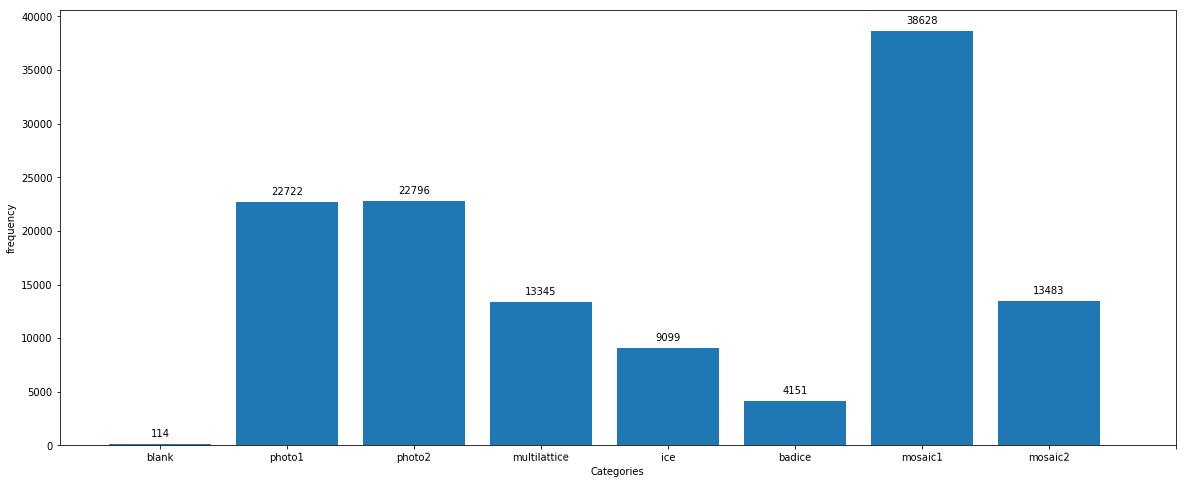

In [3]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def fill_counter(df, cats):
    counter = np.zeros(len(cats), dtype=int)
    for i, cat in enumerate(cats):
        if (cat == 'mosaic1' or cat == 'mosaic2'): 
            counter[i] = df[cat][df[cat] > 0].count()
        else: 
            counter[i] = df[cat][df[cat] == 1].count()
    return counter

categories = ['blank', 'photo1', 'photo2', 'multilattice', 'ice', 'badice', 'mosaic1', 'mosaic2']

counter = fill_counter(df_labels, categories)

fig, ax = plt.subplots(figsize=(20,8))
rects = plt.bar(['blank', 'photo1', 'photo2', 'multilattice', 'ice', 'badice', 'mosaic1', 'mosaic2'], counter, label="distribution of categories by label")
autolabel(rects)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['blank', 'photo1', 'photo2', 'multilattice', 'ice', 'badice', 'mosaic1', 'mosaic2'], rotation=0.45)
plt.ylabel('frequency')
plt.xlabel('Categories');

The images are unevenly distributed over the 6 categories and 2 numeric factors. Particularly small is the number of blank images. 

Images without crystal diffraction will be added from the first initial classification run described above.

In [5]:
df_labels_try1 = pd.read_csv('/data/hollatz/deep_learning/datasets/try1_original/categories1.txt', sep=' ', 
                        names=['quality', 'mosaic1', 'mosaic2'])
dummy = pd.get_dummies(df_labels_try1.quality)
df_labels_try1 = df_labels_try1.drop(['quality'], axis=1)
df_labels_try1_dummies = pd.concat([df_labels_try1, dummy], axis=1)
df_labels_try1_dummies.head()

,mosaic1,mosaic2,blank,good,noxtal,strong,weak
fake_00001.png,0.612610,1.361340,0,1,0,0,0
fake_00002.png,0.192174,1.467450,0,0,0,0,1
fake_00003.png,1.023000,2.745840,0,0,0,1,0
fake_00004.png,0.258349,1.788860,0,0,0,0,1
fake_00005.png,0.241990,0.803429,0,0,0,0,1


In [6]:
df_labels_try1_noxtal = df_labels_try1_dummies.drop(['mosaic1', 'mosaic2', 'good', 'strong', 'weak', 'blank'], axis=1)
not_noxtal = df_labels_try1_noxtal[df_labels_try1_noxtal.noxtal == 0].index
df_try1_noxtal = df_labels_try1_noxtal.drop(not_noxtal)
df_try1_blank = df_try1_noxtal.rename(columns={'noxtal':'blank'})
df_labels = df_labels.append(df_try1_blank, ignore_index=False, sort=False)
df_labels.fillna(0, inplace=True)
df_labels.head()

,blank,photo1,photo2,multilattice,ice,badice,mosaic1,mosaic2
fake_00001.pgm,0,1.0,0.0,0.0,1.0,0.0,0.892528,0.000000
fake_00002.pgm,0,0.0,1.0,1.0,0.0,0.0,0.581729,0.568217
fake_00003.pgm,0,1.0,0.0,0.0,0.0,0.0,0.508285,0.000000
fake_00004.pgm,0,1.0,0.0,0.0,0.0,0.0,0.852589,0.000000
fake_00005.pgm,0,0.0,1.0,0.0,0.0,0.0,0.762097,0.000000


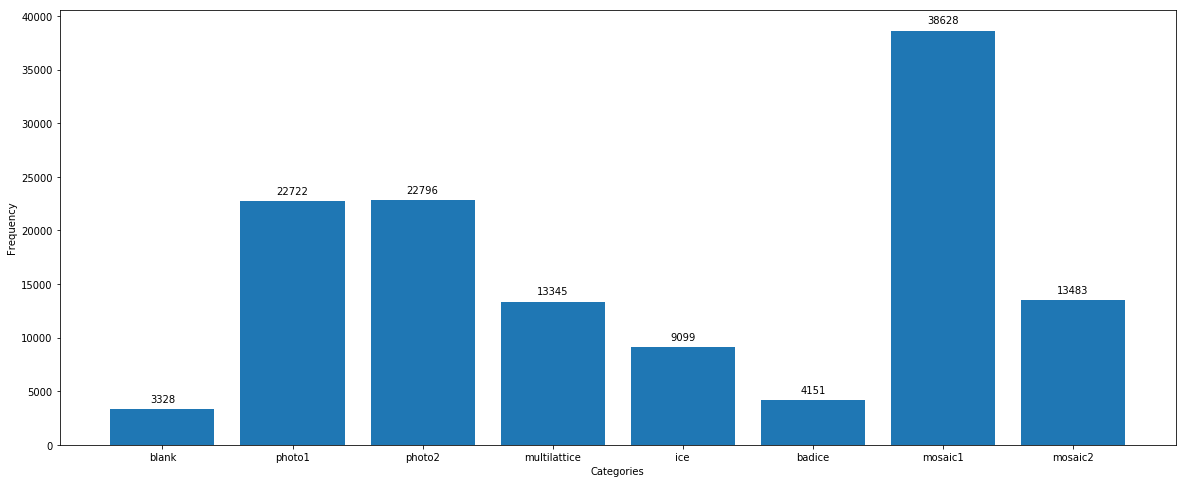

In [6]:
counter = fill_counter(df_labels, categories)
fig, ax = plt.subplots(figsize=(20,8))
rects = plt.bar(categories, counter)
autolabel(rects)
plt.ylabel('Frequency')
plt.xlabel('Categories');

Now the distribution is a little less uneven.

Checking correlations between labels is used here as a quality check for the simulation. 

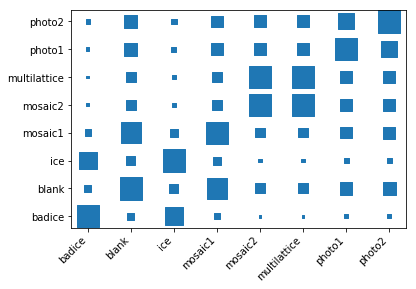

In [7]:
def heatmap(x, y, size):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
corr = df_labels[categories].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

# code from https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

As expected, correlations exist between the categories ice and badice, as well as mosaic2 
and multilattice. The correlation between blank and mosaic1 can be explained by the occurance
that mosaic1 is never 0 except in blank images. Mosaic2 varies more. There are no unexpected 
correlations between label distributions.

In [7]:
# loading the images of the original dataset
read_all_imgs = []
for img_path in glob.glob("/data/hollatz/deep_learning/datasets/try2_gray_512_pgm/png/*.png"):
    img_frame = Image.open(img_path)
    split_path = img_path.split("/")
    split_format = split_path[-1].split(".")
    split_num = split_format[0].split("_")
    img_array = np.asarray(img_frame)
    img_array = img_array.reshape((img_array.shape[0], img_array.shape[1], 1))
    read_all_imgs.append((img_array, split_num[-1]))
from operator import itemgetter
sorted_all_imgs = sorted(read_all_imgs, key=itemgetter(1))
all_imgs = np.array([ i for i,j in sorted_all_imgs])

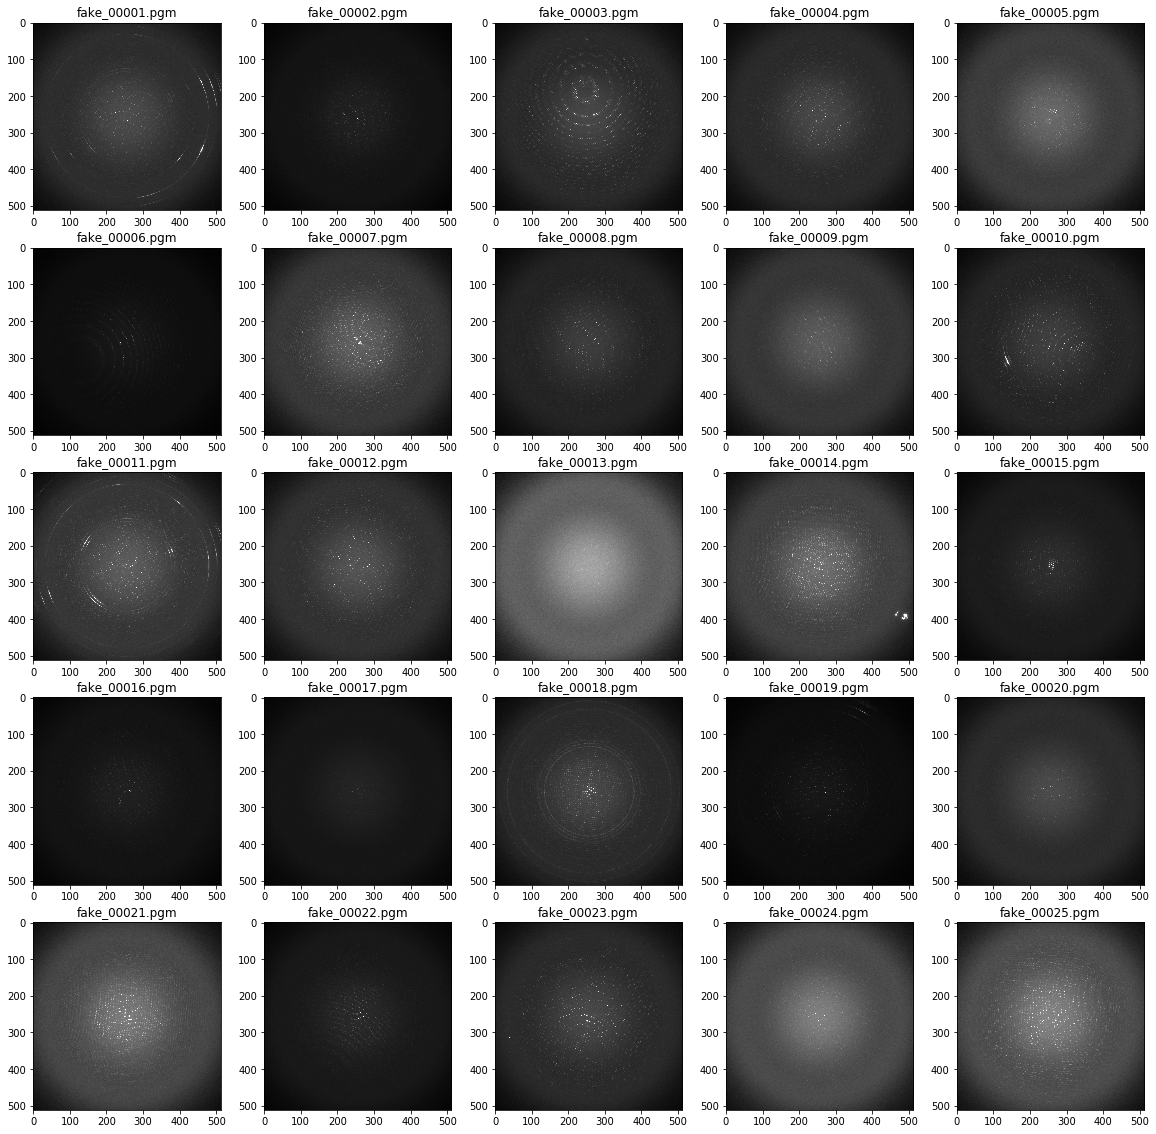

In [9]:
# display first 25 images
unique_index = pd.Index(df_labels.index)

fig = plt.figure(figsize=(20,20))
for o in range(25):
    fig.add_subplot(5, 5, o+1)
    plt.title(unique_index[o])
    plt.imshow(all_imgs[o].reshape(all_imgs[o].shape[0], all_imgs[o].shape[1]), cmap='gray')
plt.show()

In [8]:
# load additional blank images from previous dataset
noxtals = df_try1_blank.index

read_all_noxtal_imgs_try1 = []
for filename in noxtals:
    img_path = "/data/hollatz/deep_learning/datasets/try1_original/png/"+filename
    img_frame = Image.open(img_path)
    img_array = np.asarray(img_frame)
    img_array = img_array.reshape((img_array.shape[0], img_array.shape[1], 1))
    split_format = filename.split(".")
    split_num = split_format[0].split("_")
    read_all_noxtal_imgs_try1.append((img_array, split_num[-1]))

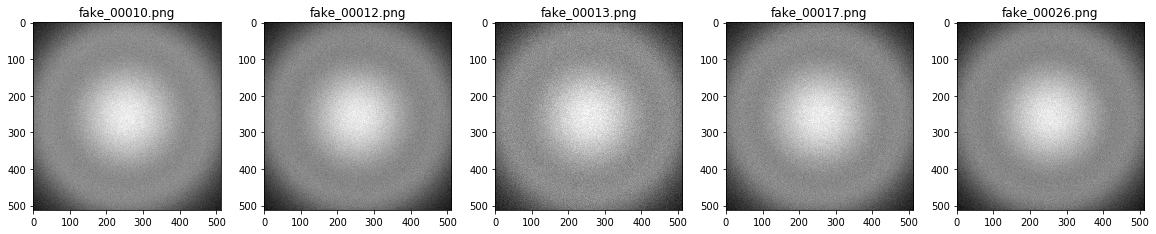

In [9]:
all_noxtal_imgs_try1 = [ i for i,j in read_all_noxtal_imgs_try1]
all_imgs_noxtal = np.array(all_noxtal_imgs_try1)

fig2 = plt.figure(figsize=(20,20))
for s, name in enumerate(noxtals[:5]):
    fig2.add_subplot(5, 5, s+1)
    plt.title(name)
    plt.imshow(all_imgs_noxtal[s].reshape(all_imgs_noxtal[s].shape[0], all_imgs_noxtal[s].shape[1]), cmap='gray')
plt.show()

In [10]:
print("original dataset: ", all_imgs.shape)
print("added blank images: ", all_imgs_noxtal.shape)
all_images = np.concatenate((all_imgs, all_imgs_noxtal))
print("combinded dataset: ", all_images.shape)

('original dataset: ', (38742, 512, 512, 1))
('added blank images: ', (3214, 512, 512, 1))
('combinded dataset: ', (41956, 512, 512, 1))


In [11]:
X_train, X_test, y_train, y_test = train_test_split(all_images, df_labels, test_size=0.33, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)
print("Training images: ", X_train.shape)
print("Training labels: ", y_train.shape)
print("Val images: ", X_val.shape)
print("Val labels: ", y_val.shape)
print("Test images: ", X_test.shape)
print("Test labels: ", y_test.shape)
y_train.head()

('Training images: ', (28110, 512, 512, 1))
('Training labels: ', (28110, 8))
('Val images: ', (9276, 512, 512, 1))
('Val labels: ', (9276, 8))
('Test images: ', (4570, 512, 512, 1))
('Test labels: ', (4570, 8))


,blank,photo1,photo2,multilattice,ice,badice,mosaic1,mosaic2
fake_00174.pgm,0,1.0,0.0,0.0,0.0,0.0,0.762905,0.0
fake_38577.pgm,0,0.0,1.0,0.0,0.0,0.0,0.712220,0.0
fake_02902.pgm,0,1.0,0.0,0.0,0.0,0.0,0.747976,0.0
fake_18087.pgm,0,1.0,0.0,0.0,0.0,0.0,0.739703,0.0
fake_13253.pgm,0,0.0,1.0,0.0,0.0,0.0,0.728974,0.0


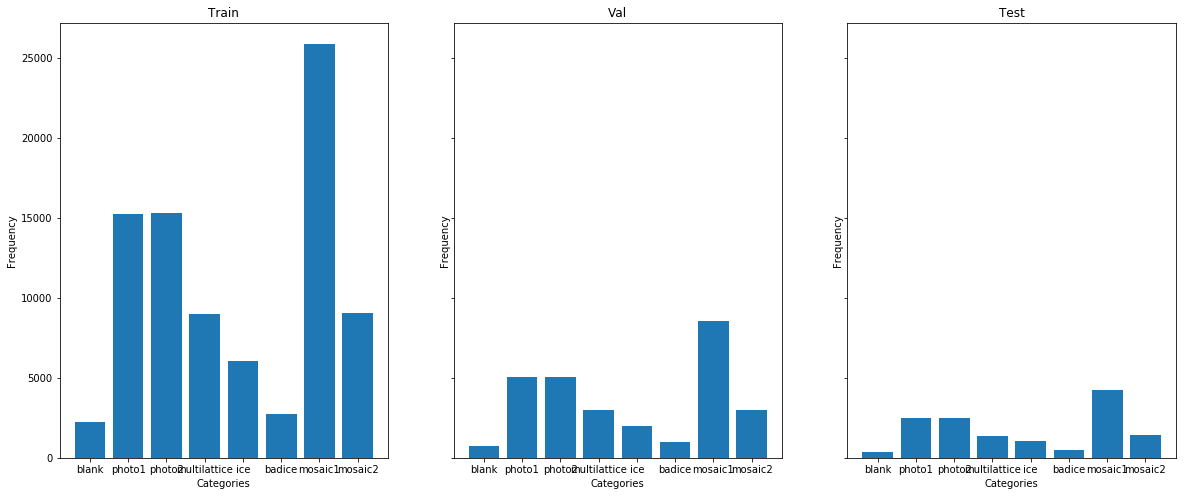

In [15]:
counter_train = fill_counter(y_train, categories)
counter_val = fill_counter(y_val, categories)
counter_test = fill_counter(y_test, categories)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,8), sharey=True)
rects_0 = ax[0].bar(categories, counter_train)
ax[0].set_title("Train")
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Categories');
rects_1 = ax[1].bar(categories, counter_val)
ax[1].set_title("Val")
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Categories');
rects_2 = ax[2].bar(categories, counter_test)
ax[2].set_title("Test")
ax[2].set_ylabel('Frequency')
ax[2].set_xlabel('Categories');

All datasets have all categories represented.

In [12]:
# creating ImageDataGenerator to add preprocessing and iterators with multiple outputs
def multiple_outputs(generator, X, y, batch_size):
    gen = generator.flow(X, y, batch_size=batchsize)
    while True:
        gnext = gen.next()
        ys_blank = [label[0] for label in gnext[1]]
        ys_photo1 = np.array([label[1] for label in gnext[1]])
        ys_photo2 = np.array([label[2] for label in gnext[1]])
        ys_multilattice = np.array([label[3] for label in gnext[1]])
        ys_ice = np.array([label[4] for label in gnext[1]])
        ys_badice = np.array([label[5] for label in gnext[1]])
        ys_mosaic1 = np.array([label[6] for label in gnext[1]])
        ys_mosaic2 = np.array([label[7] for label in gnext[1]])
        yield gnext[0], [ys_blank, ys_photo1, ys_photo2, ys_multilattice, ys_ice, ys_badice, ys_mosaic1, ys_mosaic2]

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=180,
    rescale=1./255)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

### Training

Numerous attempts have been made to find and train a suited model for this task and data. The first model was VGG16, because it achieved 90% test accuracy on the initial test of predicting the 5 classes blank, no-crystal, and weak, good and strong diffraction. The VGG16 architecture was modified to provide 8 outputs - 6 binary sigmoid classifications and 2 mean squared error regression predictions. The optimizer was Adam with a learning rate of 0.0001, which also worked well in the initial test. However, the training on this current dataset did not show any learning behavior. In fact, the initial loss increased during training instead of decreased. Different model architectures with different depths were tried, including shallow multilayer perceptrons, shallow CNNs and deep CNNs such as ResNet50, but none of them showed learning behavior. Relu and leakyReLU were applied at activation functions. The task was reduced from combined classification and regression to multi-label classification only, without success. Binary classification models in different depths were tried, without success. (By interest, please see exemplary jupyter notebooks shallow_CNN_relu.ipynb, shallow_CNN_leakyReLU.ipynb, ResNet-50.ipynb)
Finally, InceptionV3 showed learning behavior, as documented in the code blocks below. The learning rate here was reduced to 0.001. 

In [24]:
input_X = k.layers.Input(shape=(512, 512, 1), name="input")

base_model = k.applications.inception_v3.InceptionV3(include_top=False, weights = None, input_tensor=input_X, input_shape=(512, 512, 1))
# x = base_model(input_X)
x = k.layers.Flatten()(base_model.output)
blank = k.layers.Dense(units=1, activation='sigmoid', name="blank")(x)
photo1 = k.layers.Dense(units=1, activation='sigmoid', name="photo1")(x)
photo2 = k.layers.Dense(units=1, activation='sigmoid', name="photo2")(x)
multilattice = k.layers.Dense(units=1, activation='sigmoid', name="multilattice")(x)
ice = k.layers.Dense(units=1, activation='sigmoid', name="ice")(x)
badice = k.layers.Dense(units=1, activation='sigmoid', name="badice")(x)
mosaic1 = k.layers.Dense(units=1, activation=None, name="mosaic1")(x)
mosaic2 = k.layers.Dense(units=1, activation=None, name="mosaic2")(x)

model = k.Model(inputs=input_X, outputs=[blank, photo1, photo2, multilattice, ice, badice, mosaic1, mosaic2])

In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_377 (Conv2D)             (None, 255, 255, 32) 288         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_377 (BatchN (None, 255, 255, 32) 96          conv2d_377[0][0]                 
__________________________________________________________________________________________________
activation_377 (Activation)     (None, 255, 255, 32) 0           batch_normalization_377[0][0]    
__________________________________________________________________________________________________
conv2d_378

In [27]:
model.compile(loss=['binary_crossentropy', 'binary_crossentropy', 'binary_crossentropy', 'binary_crossentropy', \
                         'binary_crossentropy', 'binary_crossentropy', 'mse', 'mse'],
                   optimizer=k.optimizers.Adam(0.001))

In [28]:
epochs = 20
batchsize = 32

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = k.callbacks.ModelCheckpoint("multitask_inception_fromScratch.h5", save_best_only=True)

train_gen = multiple_outputs(train_datagen, X_train, y_train, batchsize)
val_gen = multiple_outputs(val_datagen, X_val, y_val, batchsize)

In [29]:
history = model.fit_generator(train_gen, 
                    validation_data=val_gen,
                    steps_per_epoch=len(X_train) / batchsize,
                    validation_steps=len(X_val) / batchsize,
                    shuffle=True,
                    callbacks=[callback],
                    epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
878/878 [==============================] - 661s 753ms/step - loss: 105.9468 - blank_loss: 1.2760 - photo1_loss: 7.2972 - photo2_loss: 7.2538 - multilattice_loss: 5.1433 - ice_loss: 3.4685 - badice_loss: 1.5571 - mosaic1_loss: 39.5463 - mosaic2_loss: 40.4045 - val_loss: 29.7936 - val_blank_loss: 1.3002 - val_photo1_loss: 7.2868 - val_photo2_loss: 7.3178 - val_multilattice_loss: 5.1781 - val_ice_loss: 3.4927 - val_badice_loss: 1.6714 - val_mosaic1_loss: 1.3851 - val_mosaic2_loss: 2.1615
Epoch 2/20
878/878 [==============================] - 516s 588ms/step - loss: 26.2317 - blank_loss: 1.2766 - photo1_loss: 7.3083 - photo2_loss: 7.2598 - multilattice_loss: 5.1439 - ice_loss: 3.4724 - badice_loss: 1.5596 - mosaic1_loss: 0.0784 - mosaic2_loss: 0.1327 - val_loss: 27.5765 - val_blank_loss: 1.2955 - val_photo1_loss: 7.2969 - val_photo2_loss: 7.3107 - val_multilattice_loss: 5.1803 - val_ice_loss: 3.5099 - val_badice_loss: 1.6791 - val_m

In [30]:
model.save("multitask_inception_fromScratch.h5")

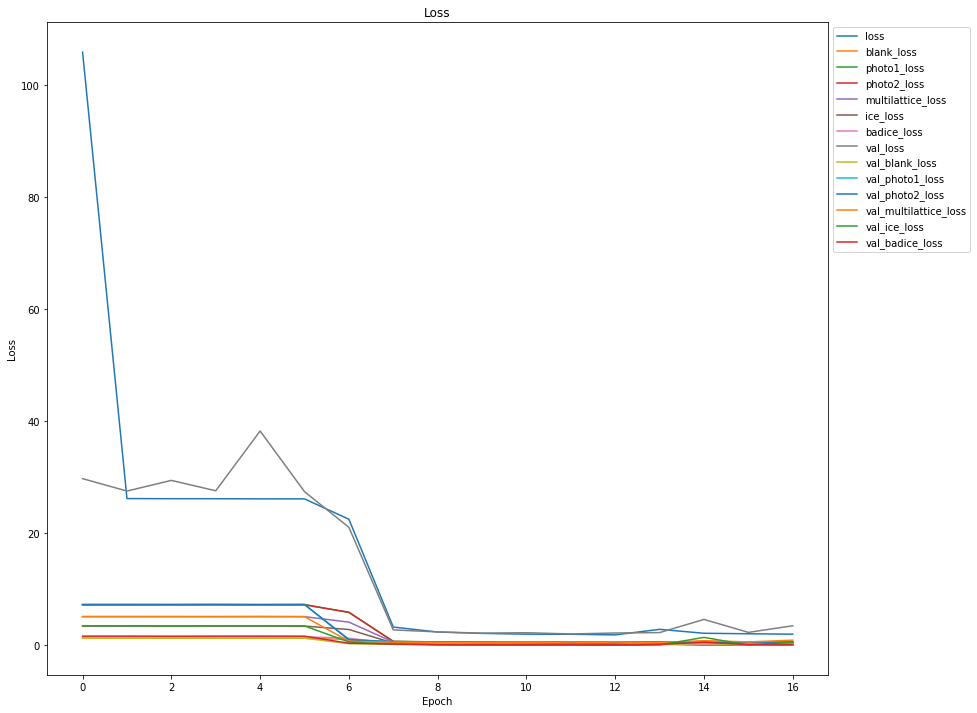

In [43]:
def plot_history(history, response_list, title, xlabel):
    fig, ax = plt.subplots(figsize=(14,12))
    for response in response_list:
        plt.plot(history.history[response])
    plt.title(title)
    plt.ylabel(title)
    plt.xlabel(xlabel)
    lgd = plt.legend(response_list, loc='upper left', bbox_to_anchor=(1, 1))
    lgd.FontSize = 40
    plt.show()

resp_loss = ['loss', 'blank_loss','photo1_loss', 'photo2_loss', 'multilattice_loss', 'ice_loss', 'badice_loss', \
            'val_loss', 'val_blank_loss', 'val_photo1_loss', 'val_photo2_loss', 'val_multilattice_loss', \
            'val_ice_loss', 'val_badice_loss']

plot_history(history, resp_loss, 'Loss', 'Epoch')

In [44]:
predictions = model.predict(X_test)

In [48]:
def print_cm(y_true, y_pred, category):
    cm = metrics.confusion_matrix(y_true, y_pred)
    print("\n {}: \n {}".format(category, cm))
    return cm

cm_blank = print_cm(y_test.blank.values, predictions[0], 'blank')
cm_photo1 = print_cm(y_test.photo1.values, predictions[1], 'photo1')
cm_photo2 = print_cm(y_test.photo2.values, predictions[2], 'photo2')
cm_multi = print_cm(y_test.multilattice.values, predictions[3], 'multilattice')
cm_ice = print_cm(y_test.ice.values, predictions[4], 'ice')
cm_badice = print_cm(y_test.badice.values, predictions[5], 'badice')


 blank: 
 [[4216    0]
 [ 354    0]]

 photo1: 
 [[   0 2109]
 [   0 2461]]

 photo2: 
 [[   0 2101]
 [   0 2469]]

 multilattice: 
 [[   0 3179]
 [   0 1391]]

 ice: 
 [[3533    2]
 [1030    5]]

 badice: 
 [[   0 4099]
 [   0  471]]


Accuracies:
blank: 92.25% (due to small number of blank images)
photo1: 53.85% (machtes chance, since the diffraction comes either from photo1 or photo2)
photo2: 54.03%
multilattice: 30.44%
ice: 77.41% (mainly predicts no ice diffraction)
badice: 10.3%

In [61]:
print "predictions mosaic1: ", predictions[6]
print "\n predictions mosaic2: ", predictions[7]

predictions mosaic1:  [[390.75705]
 [417.0469 ]
 [422.04663]
 ...
 [692.19995]
 [583.3108 ]
 [545.47034]]

 predictions mosaic2:  [[-125.385704]
 [-127.97673 ]
 [-126.544975]
 ...
 [-214.80481 ]
 [-171.07031 ]
 [-165.28854 ]]


Even though, InceptionV3 showed learning behavior and printed low loss numbers per category during training, the performace on the test set is poor. The model predicted mainly, that images either belong all to individual categories or none. The predictions for the mosaicity parameters are far off from the target values within a range between 0 and 1. The data pipeline was thoroughly checked to ensure that the models were fed the matching pairs of images and labels. Due to the projects time constraints will these disappointing results not be further investigated at this point and postponed for future analysis. Instead, the different approach of transfer learning is attempted in the next section.

The difficulties to find a suitable model for this task and dataset come as a surprise, since the initial categorization tests of diffraction images was straight forward and did not require any kind of special treatment. The reasons might be 1) the added comblexity due to the combined classification and regression tasks in one single model and 2) the added complexity in the dataset, as described above. The differences between categories are smaller in this particular dataset than in the previous one. Furthermore, the differences within a category might be larger than the differences between categories.

### Transfer Learning

Since the initial classification was successful with 90% test accuracy on the categories blank, no-crystal, and weak, good, and strong diffraction, this model will be used for transfer learning on this task and dataset. The used architecture was VGG16, trained on 8308 gray images with size 512x512 in png format. The applied optimizer was Adam with a used learning rate of 0.0001 (for further details, see jupyter notebook try1_multiclass_VGG16). This model will be adjusted to 8 outputs.

In [62]:
base_model = k.models.load_model('./VGG16_categorical_try1.h5')
base_model = k.Model(inputs=base_model.input, outputs=base_model.layers[-4].output)
# print(base_model.summary())

x = base_model.output
x = k.layers.Dense(4096, activation='relu')(x)
x = k.layers.Dense(4096, activation='relu')(x)

blank = k.layers.Dense(units=1, activation='sigmoid', name="blank")(x)
photo1 = k.layers.Dense(units=1, activation='sigmoid', name="photo1")(x)
photo2 = k.layers.Dense(units=1, activation='sigmoid', name="photo2")(x)
multilattice = k.layers.Dense(units=1, activation='sigmoid', name="multilattice")(x)
ice = k.layers.Dense(units=1, activation='sigmoid', name="ice")(x)
badice = k.layers.Dense(units=1, activation='sigmoid', name="badice")(x)
mosaic1 = k.layers.Dense(units=1, activation=None, name="mosaic1")(x)
mosaic2 = k.layers.Dense(units=1, activation=None, name="mosaic2")(x)

model = k.Model(inputs=base_model.input, outputs=[blank, photo1, photo2, multilattice, ice, badice, mosaic1, mosaic2])

The first 3 convolutional layers are frozen, to keep the pretrained weights from changing. Only the last 2 convolutional blocks and the final 2 dense layers will be retrained on the current dataset. The number of frozen and trainable convolutional blocks were determined by trial and error. The learning rate was increased to 0.001 for increased training speed.

In [63]:
for layer in model.layers[:]:
    layer.trainable = False
for layer in model.layers[11:]:
    layer.trainable = True
for layer in model.layers:
    print(layer, layer.trainable)

(<keras.engine.input_layer.InputLayer object at 0x7f7449d1a350>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f7449d1a310>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f7449d1a490>, False)
(<keras.layers.pooling.MaxPooling2D object at 0x7f7449d1a4d0>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f7449d1a650>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f7449d1a710>, False)
(<keras.layers.pooling.MaxPooling2D object at 0x7f7449d1a810>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f7449d1a890>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f7449d1a990>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f7449d1aa90>, False)
(<keras.layers.pooling.MaxPooling2D object at 0x7f7449d1ab90>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f7449d1ac10>, True)
(<keras.layers.convolutional.Conv2D object at 0x7f7449d1ad10>, True)
(<keras.layers.convolutional.Conv2D object at 0x7f7449d1ae10>, True)
(<keras.layers.poolin

In [64]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 640         input[0][0]                      
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [65]:
model.compile(loss=['binary_crossentropy', 'binary_crossentropy', 'binary_crossentropy', 'binary_crossentropy', \
                         'binary_crossentropy', 'binary_crossentropy', 'mse', 'mse'],
                   optimizer=k.optimizers.Adam(0.001),
                   metrics=['acc', 'mse'])

In [12]:
checkpoint = k.callbacks.ModelCheckpoint("multitask_VGG16_transfer.h5", save_best_only=True)

history = model.fit_generator(train_gen, 
                    validation_data=val_gen,
                    steps_per_epoch=len(X_train) / batchsize,
                    validation_steps=len(X_val) / batchsize,
                    shuffle=True,
                    callbacks=[callback, checkpoint],
                    epochs=epochs,
                    verbose=0)

model = k.models.load_model('multitask_VGG16_transfer.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [13]:
predictions = model.predict(X_test)

In [16]:
def print_cm(y_true, y_pred, category):
    cm = metrics.confusion_matrix(y_true, y_pred)
    print("\n {}: \n {}".format(category, cm))
    return cm

cm_blank = print_cm(y_test.blank.values, np.rint(predictions[0]), 'blank')
cm_photo1 = print_cm(y_test.photo1.values, np.rint(predictions[1]), 'photo1')
cm_photo2 = print_cm(y_test.photo2.values, np.rint(predictions[2]), 'photo2')
cm_multi = print_cm(y_test.multilattice.values, np.rint(predictions[3]), 'multilattice')
cm_ice = print_cm(y_test.ice.values, np.rint(predictions[4]), 'ice')
cm_badice = print_cm(y_test.badice.values, np.rint(predictions[5]), 'badice')


 blank: 
 [[4216    0]
 [ 354    0]]

 photo1: 
 [[2055   54]
 [2141  320]]

 photo2: 
 [[ 182 1919]
 [  39 2430]]

 multilattice: 
 [[2380  799]
 [ 272 1119]]

 ice: 
 [[   0 3535]
 [   0 1035]]

 badice: 
 [[ 195 3904]
 [  39  432]]


Accuracies:
blank: 92.25% (due to small number of blank images)
photo1: 51.96% (machtes chance, since the diffraction comes either from photo1 or photo2)
photo2: 57.16%
multilattice: 76.56% (significant improvement from 30.44%)
ice: 22.64% (predicts all images as ice diffraction, previously predicted no ice diffraction)
badice: 13.71%

In [17]:
print "predictions mosaic1: ", predictions[6]
print "\n predictions mosaic2: ", predictions[7]

predictions mosaic1:  [[35.423866]
 [38.74751 ]
 [31.708158]
 ...
 [64.58991 ]
 [90.98177 ]
 [57.279984]]

 predictions mosaic2:  [[  3.5366552]
 [ 31.342205 ]
 [ 19.191032 ]
 ...
 [ 51.9433   ]
 [112.99737  ]
 [ 53.71555  ]]


These predictions are better, because they show more variety. The inception model predicted mainly, that images either belong all to individual categories or none. The predictions for the mosaicity parameters were several hundred units off from the target values within a range between 0 and 1. Now, categories photo1, photo2 and multilattice show a distribution over all possible outcomes. Multilattice has a significantly increased accuracy from 30% to 76%. Ice and blank still need show an all-or-nothing prediction and need improvement. The predicted mosaicity values are still very far off with several ten units, but closer to the target values.

#### Exemplary Binary Classifications with Transfer Learning

To get an idea of the achievable accuracy per category binary classifications are performed. Blank and no-crystal diffraction images can achieve an accuracy of 90% as seen in the initial classification test. Categories of interest here are ice diffraction, multilattice, and one of the photosystem proteins. Two binary classifiers for the categories ice and multilattice have been trained. Please see details in the separate jupyter notebooks Binary_Ice_VGG16-transfer_last_2_ConvBlocks.ipynb and Binary_Multilattice_VGG16-transfer_last_2_ConvBlocks.ipynb. The achieved test accuracy for ice was 89.7% (best score so far) and for multilattice 33.5% (worse than the transfer learning multitask result).

### Discussion and Conclusion

The overall task turned out to be more difficult than expected. First initial test with classifiers for diffraction images were very promising. However, the task of training a single model for classification and regression with a more complex dataset made it difficult to find a suitable model. Different model architectures in varying depth, with different learning rates and activation functions were trained without achieving significantly better performance than chance. The task was broken down to classification (multilabel) only and further to single binary classification, without success again. 
The approach of transfer learning made a difference where a classifier from the initial test was taken, adjusted to the current task and retrained on the current dataset. Probably due to the fact, that certain features of diffraction images were extracted during the initial training, jumpstarted the training on the current dataset. 

The achieved accuracies in multitask learning are:
blank: 92.25% (due to small number of blank images)
photo1: 51.96% (machtes chance, since the diffraction comes either from photo1 or photo2)
photo2: 57.16%
multilattice: 76.56% (significant improvement from 30.44%)
ice: 22.64% (predicts all images as ice diffraction, previously predicted no ice diffraction)
badice: 13.71%

These predictions are better, because they show more variety. The inception model predicted mainly, that images either belong all to individual categories or none. The predictions for the mosaicity parameters were several hundred units off from the target values within a range between 0 and 1. Now, categories photo1, photo2 and multilattice show a distribution over all possible outcomes. Multilattice has a significantly increased accuracy from 30% to 76%. Ice and blank still need show an all-or-nothing prediction and need improvement. The predicted mosaicity values are still very far off with several ten units, but closer to the target values.

The next steps are to train linear and multi-linear regression models separately to predict the mosaicity factors. This way, it is possible to get insight about the smallest achievable error. Also, a binary classifier for photo1 ore photo2 needs to be trained to get a benchmark target score for further multitask developments.VGG16 is a relatively old model architecture. The approach of transfer learning will be attempted with more advanced models that have been developed in recent years.Once the accuracies and mean squared errors can be improved, more categories and numeric factors will be added to achieve the overall goal of training an advanced, highly model that can support the research field of crystallography.